In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
gamma = 1.4
real = np.float64
@numba.njit
def weno(s: real) -> real:
  # WENO Z5. Ref: https://doi.org/10.1016/j.jcp.2007.11.038
  eps = 1e-6
  v = np.empty((3,), dtype=real)
  beta = np.empty((3,), dtype=real)

  beta[2] = (13. / 12.) * (s[4] - 2 * s[3] + s[2])**2 + 0.25 * (s[4] - 4 * s[3] + 3 * s[2])**2
  beta[1] = (13. / 12.) * (s[3] - 2 * s[2] + s[1])**2 + 0.25 * (s[3] - s[1])**2
  beta[0] = (13. / 12.) * (s[2] - 2 * s[1] + s[0])**2 + 0.25 * (3 * s[2] - 4 * s[1] + s[0])**2

  tau = np.abs(beta[2] - beta[0])
  beta[2] = 1.0 + tau / (eps + beta[2])
  beta[1] = (1.0 + tau / (eps + beta[1])) * 6.0
  beta[0] = (1.0 + tau / (eps + beta[0])) * 3.0
  beta1 = 1.0 / (beta[2] + beta[1] + beta[0])

  v[2] = 11 * s[2] - 7 * s[3] + 2 * s[4]
  v[1] = -s[3] + 5 * s[2] + 2 * s[1]
  v[0] = 2 * s[2] + 5 * s[1] - s[0]

  sm = beta1 / 6.0 * (beta[2] * v[2] + beta[1] * v[1] + beta[0] * v[0])
  # if (np.isnan(sm)): print("WARNING: isnan(sm)")
  return sm

@numba.njit
def cons2prim(U: real) -> real:
  rho = U[:,0]
  u = U[:,1] / U[:,0]
  p = (gamma - 1) * (U[:,2] - 0.5 * rho * u**2)

  q = np.zeros((U.shape[0], 4), dtype=real)
  q[:,0] = rho
  q[:,1] = u
  q[:,2] = p
  q[:,3] = np.sqrt(gamma*p/rho) # c
  return q

@numba.njit
def rk3_euler(U: real, dx: real, dt: real, bc_type: str = "FOExtrap") -> real:
  # SSP-RK3
  U1 = U + dt * (rhs_euler(U, dx, bc_type))
  U2 = 0.75 * U + 0.25 * (U1 + dt * (rhs_euler(U1, dx, bc_type)))
  return (U + 2*(U2 + dt * (rhs_euler(U2, dx, bc_type)))) / 3

@numba.njit
def fill_ghost_cell(ng: int, U: real, bc_type: str) -> real:
  U_border = np.zeros((U.shape[0]+2*ng, U.shape[1]), dtype=real)
  U_border[ng:-ng,:] = U
  if bc_type == "FOExtrap":
    U_border[:ng,:] = U[0,:]
    U_border[-ng:,:] = U[-1,:]
  elif bc_type == "periodic":
    U_border[:ng,:] = U[-ng:,:]
    U_border[-ng:,:] = U[:ng,:]
  # elif bc_type == "reflect":
  #   U_border[:ng,:] = U[ng:-1:,:]
  #   U_border[-ng:,:] = U[-ng:-1:,:]
  else:
    raise NotImplementedError
  return U_border

def riemann_ic(x, rl, ul, pl, rr, ur, pr):
  U = np.zeros((x.shape[0], 3))
  U_l0 = [rl, rl*ul, pl/(gamma-1.) + 0.5*rl*ul**2]
  U_r0 = [rr, rr*ur, pr/(gamma-1.) + 0.5*rr*ur**2]
  U[x < 0] = [U_l0]
  U[x >= 0] = [U_r0]
  return U

## Without automatic differentiation

In [3]:
@numba.njit
def rhs_euler(U: real, dx: real, bc_type: str = "FOExtrap") -> real:
  # Fill ghost cells
  ng = 3
  U_border = fill_ghost_cell(ng, U, bc_type)

  # Compute fluxes
  Q = cons2prim(U_border)
  flx = np.zeros((U.shape[0]+1, U.shape[1]), dtype=real)

  # characteristic transform

  for i in range(U.shape[0]+1):
    # Characteristic transformation
    q = Q[i:i+2*ng,:]
    rho = q[:,0]
    u = q[:,1]
    p = q[:,2]
    c = q[:,3]
    re = U_border[i:i+2*ng,2]
    rl, rr = rho[ng-1], rho[ng]
    ul, ur = u[ng-1], u[ng]
    rel, rer = re[ng-1], re[ng]
    pl, pr = p[ng-1], p[ng]
    u_roe = (ul*np.sqrt(rl) + ur*np.sqrt(rr)) / (np.sqrt(rl) + np.sqrt(rr))
    h_roe = ((rel+pl)/np.sqrt(rl) + (rer+pr)/np.sqrt(rr)) / (np.sqrt(rl) + np.sqrt(rr))
    c_roe = np.sqrt((gamma-1)*(h_roe-u_roe**2/2))
    L = 0.5 / c_roe**2 * np.array([[u_roe*c_roe+u_roe**2*(gamma-1)/2, -c_roe-u_roe*(gamma-1), gamma-1],
                                   [2*(h_roe-u_roe**2)*(gamma-1),      2*u_roe*(gamma-1),     2*(1-gamma)],
                                   [-u_roe*c_roe+u_roe**2*(gamma-1)/2, c_roe-u_roe*(gamma-1), gamma-1]], dtype=real)
    R = np.array([[1.,1.,1.], [u_roe-c_roe, u_roe, u_roe+c_roe], [h_roe-u_roe*c_roe, u_roe**2/2, h_roe+u_roe*c_roe]], dtype=real)

    # Flux splitting
    f = np.zeros((2*ng, 3), dtype=real)
    f[:,0] = rho * u
    f[:,1] = rho * u**2 + p
    f[:,2] = u * (re + p)
    # w = f@L.T

    alpha = np.max(c + np.abs(u))
    # alpha = np.max(Q[:,3] + np.abs(Q[:,1]))
    fp = (f + alpha*U_border[i:i+2*ng,:]) / 2
    fm = (f - alpha*U_border[i:i+2*ng,:]) / 2
    wp = fp@L.T
    wm = fm@L.T
    # wp = (w + alpha*U_border[i:i+2*ng,:]) / 2
    # wm = (w - alpha*U_border[i:i+2*ng,:]) / 2

    for j in range(3):
      fpL = weno(np.flip(wp[ :2*ng-1,j]))
      fmR = weno(        wm[1:2*ng,  j])
      flx[i,j] = fpL + fmR
    flx[i,:] = flx[i,:]@R.T

  return (flx[:-1,:] - flx[1:,:]) / dx

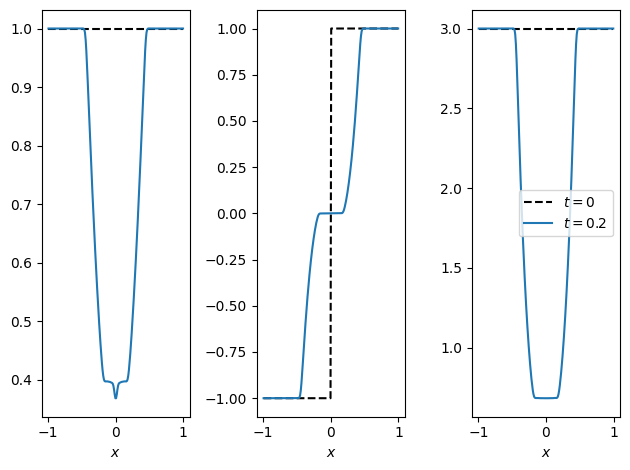

In [4]:
x = np.linspace(-1.0, 1.0, 201, dtype=real)
x = (x[:-1] + x[1:]) / 2
u = riemann_ic(x, rl=1, ul=-1, pl=1, rr=1, ur=1, pr=1)
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(x, u[:,i], 'k--', label=rf"$t = 0$")

dx = x[1] - x[0]
t_end = 0.2
dt = 0.001

for _ in range(int(t_end/dt)):
    u = rk3_euler(u, dx, dt,bc_type="FOExtrap")

for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(x, u[:,i], label=rf"$t = {t_end}$")
  plt.xlabel("$x$")
plt.legend()
plt.tight_layout()